# Phase 1: Data Collection - Study Resource Recommender

## Project Overview
**Goal:** Build a Study Resource Recommender that analyzes student quiz performance and recommends relevant YouTube educational videos.

**Input:** Student quiz results  
**Output:** Topic or YouTube Video recommendations

---

## Datasets Used

### Dataset 1: ASSISTments 2009-2010 (Student Quiz Performance)
- **Source:** https://sites.google.com/site/assistmentsdata/home/2009-2010-assistment-data/skill-builder-data-2009-2010
- **Description:** Online tutoring platform data with student interactions on math problems
- **Size:** ~346,860 interactions, 4,217 students, 123 skills
- **Key Features:** Student ID, Problem ID, Skill Name, Correctness, Hints Used, Time Taken

### Dataset 2: Khan Academy YouTube Videos (Educational Resources)
- **Source:** https://www.kaggle.com/datasets/zq1200/khan-academy-youtube-channel
- **Description:** Educational videos from Khan Academy's YouTube channel
- **Key Features:** Video ID, Title, Views, Likes, Duration, Topic

### Connection Between Datasets
Both datasets are connected through **SKILL/TOPIC** - the skill name from ASSISTments can be matched to video titles/topics from Khan Academy.

```
ASSISTments skill_name: "Adding Fractions" → Khan Academy video: "Adding Fractions with Unlike Denominators"
```

## 1. Import Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Load Dataset 1: ASSISTments 2009-2010

Download the dataset from: https://drive.google.com/file/d/0B2X0QD6q79ZJUFU1cjYtdGhVNjg/view

Or use Kaggle: https://www.kaggle.com/datasets/nicolaswattiez/skillbuilder-data-2009-2010

In [15]:
# Load ASSISTments dataset
# Update the path to where you saved the file
assistments_df = pd.read_csv('/content/skill_builder_data.csv', encoding='ISO-8859-1', low_memory=False)

print(f"Dataset Shape: {assistments_df.shape}")
print(f"Number of Students: {assistments_df['user_id'].nunique()}")
print(f"Number of Problems: {assistments_df['problem_id'].nunique()}")
print(f"Number of Skills: {assistments_df['skill_name'].nunique()}")

Dataset Shape: (20793, 30)
Number of Students: 1172
Number of Problems: 1671
Number of Skills: 7


In [17]:
# View first few rows
assistments_df.head()

,order_id,assignment_id,user_id,assistment_id,problem_id,original,correct,attempt_count,ms_first_response,tutor_mode,answer_type,sequence_id,student_class_id,position,type,base_sequence_id,skill_id,skill_name,teacher_id,school_id,hint_count,hint_total,overlap_time,template_id,answer_id,answer_text,first_action,bottom_hint,opportunity,opportunity_original
0,33022537,277618,64525,33139,51424,1,1,1,32454,tutor,algebra,5948,13241,126,MasterySection,5948,1,Box and Whisker,22763.0,73.0,0.0,3.0,32454.0,30799.0,NaN,26,0.0,NaN,1.0,1.0
1,33022709,277618,64525,33150,51435,1,1,1,4922,tutor,algebra,5948,13241,126,MasterySection,5948,1,Box and Whisker,22763.0,73.0,0.0,3.0,4922.0,30799.0,NaN,55,0.0,NaN,2.0,2.0
2,35450204,220674,70363,33159,51444,1,0,2,25390,tutor,algebra,5948,11816,22,MasterySection,5948,1,Box and Whisker,22763.0,73.0,0.0,3.0,42000.0,30799.0,NaN,88,0.0,NaN,1.0,1.0
3,35450295,220674,70363,33110,51395,1,1,1,4859,tutor,algebra,5948,11816,22,MasterySection,5948,1,Box and Whisker,22763.0,73.0,0.0,3.0,4859.0,30059.0,NaN,41,0.0,NaN,2.0,2.0
4,35450311,220674,70363,33196,51481,1,0,14,19813,tutor,algebra,5948,11816,22,MasterySection,5948,1,Box and Whisker,22763.0,73.0,3.0,4.0,124564.0,30060.0,NaN,65,0.0,0.0,3.0,3.0


In [18]:
# Check column names and data types
print("Columns in ASSISTments dataset:")
print(assistments_df.dtypes)

Columns in ASSISTments dataset:
order_id                  int64
assignment_id             int64
user_id                   int64
assistment_id             int64
problem_id                int64
original                  int64
correct                   int64
attempt_count             int64
ms_first_response         int64
tutor_mode               object
answer_type              object
sequence_id               int64
student_class_id          int64
position                  int64
type                     object
base_sequence_id          int64
skill_id                  int64
skill_name               object
teacher_id              float64
school_id               float64
hint_count              float64
hint_total              float64
overlap_time            float64
template_id             float64
answer_id               float64
answer_text              object
first_action            float64
bottom_hint             float64
opportunity             float64
opportunity_original    float64
dtype: o

In [19]:
# Check for missing values
print("Missing Values:")
missing_pct = (assistments_df.isnull().sum() / len(assistments_df) * 100).round(2)
print(missing_pct[missing_pct > 0])

Missing Values:
answer_id      100.00
answer_text     10.22
bottom_hint     83.12
dtype: float64


## 3. Clean Dataset 1: ASSISTments

In [20]:
# Select relevant columns for our recommender system
relevant_columns = [
    'order_id',
    'user_id',
    'problem_id',
    'skill_id',
    'skill_name',
    'correct',
    'attempt_count',
    'ms_first_response',
    'hint_count',
    'hint_total',
    'first_action',
    'opportunity'
]

# Keep only relevant columns
assistments_clean = assistments_df[relevant_columns].copy()
print(f"Shape after column selection: {assistments_clean.shape}")

Shape after column selection: (20793, 12)


In [21]:
# Remove rows with missing skill_name (we need skills for recommendations)
print(f"Rows before removing missing skills: {len(assistments_clean)}")
assistments_clean = assistments_clean.dropna(subset=['skill_name'])
print(f"Rows after removing missing skills: {len(assistments_clean)}")

Rows before removing missing skills: 20793
Rows after removing missing skills: 20792


In [22]:
# Clean skill names - standardize format
assistments_clean['skill_name'] = assistments_clean['skill_name'].str.strip().str.lower()

# View unique skills
unique_skills = assistments_clean['skill_name'].unique()
print(f"Number of unique skills: {len(unique_skills)}")
print("\nSample skills:")
for skill in sorted(unique_skills)[:20]:
    print(f"  - {skill}")

Number of unique skills: 7

Sample skills:
  - box and whisker
  - circle graph
  - histogram as table or graph
  - number line
  - scatter plot
  - stem and leaf plot
  - table


In [23]:
# Handle negative or invalid values
assistments_clean['attempt_count'] = assistments_clean['attempt_count'].clip(lower=1)
assistments_clean['hint_count'] = assistments_clean['hint_count'].clip(lower=0)
assistments_clean['ms_first_response'] = assistments_clean['ms_first_response'].clip(lower=0)

# Fill missing hint_total with median
assistments_clean['hint_total'] = assistments_clean['hint_total'].fillna(
    assistments_clean['hint_total'].median()
)

In [25]:
# Create derived features for student performance analysis

# Hint usage ratio (how many hints used out of available)
assistments_clean['hint_ratio'] = (
    assistments_clean['hint_count'] / assistments_clean['hint_total'].replace(0, 1)
).clip(0, 1)

# Response time in seconds
assistments_clean['response_time_sec'] = assistments_clean['ms_first_response'] / 1000

# Binary: did student ask for hint first?
assistments_clean['asked_hint_first'] = (
    assistments_clean['first_action']
    .astype(str)
    .str.lower()
    .eq('hint')
).astype(int)

print("Derived features created!")
assistments_clean.head()

Derived features created!


,order_id,user_id,problem_id,skill_id,skill_name,correct,attempt_count,ms_first_response,hint_count,hint_total,first_action,opportunity,hint_ratio,response_time_sec,asked_hint_first
0,33022537,64525,51424,1,box and whisker,1,1,32454,0.0,3.0,0.0,1.0,0.00,32.454,0
1,33022709,64525,51435,1,box and whisker,1,1,4922,0.0,3.0,0.0,2.0,0.00,4.922,0
2,35450204,70363,51444,1,box and whisker,0,2,25390,0.0,3.0,0.0,1.0,0.00,25.390,0
3,35450295,70363,51395,1,box and whisker,1,1,4859,0.0,3.0,0.0,2.0,0.00,4.859,0
4,35450311,70363,51481,1,box and whisker,0,14,19813,3.0,4.0,0.0,3.0,0.75,19.813,0


## 4. Load Dataset 2: Khan Academy YouTube Videos

Download from: https://www.kaggle.com/datasets/zq1200/khan-academy-youtube-channel

In [28]:
# Load Khan Academy YouTube dataset
# Update the path to where you saved the file


khan_videos_df = pd.read_csv(
    '/content/youtube_khan_academy.csv',
    engine='python',
    on_bad_lines='skip'
)

print(f"Dataset Shape: {khan_videos_df.shape}")
print(f"Number of Videos: {len(khan_videos_df)}")


Dataset Shape: (4471, 58)
Number of Videos: 4471


In [29]:
# View first few rows
khan_videos_df.head()

,channel_title,videoId,title,title_word_count,published_at,date_diff,view_count,like_count,dislike_count,reaction_total,like_dislike_diff,like_percentage,dislike_percentage,favorite_count,views_per_day,comment_count,tokenized,live_broadcast_content,url,description,description_word_count,tokenized_description,duration,aspect_ratio,extract_date,...,diff_sentiment_polarity,diff_sentiment_subjectivity,title_flesch_reading_ease,title_smog_index,title_flesch_kincaid_grade,title_coleman_liau_index,title_automated_readability_index,title_dale_chall_readability_score,title_difficult_words,title_linsear_write_formula,title_gunning_fog,title_text_standard,desc_flesch_reading_ease,desc_smog_index,desc_flesch_kincaid_grade,desc_coleman_liau_index,desc_automated_readability_index,desc_dale_chall_readability_score,desc_difficult_words,desc_linsear_write_formula,desc_gunning_fog,desc_text_standard,publish_year,publish_week_month,publish_week_start_date
0,Khan Academy,G5FVxAzlmfM,Weak acid–weak base reactions | Acids and base...,14,2021-08-11T00:42:40Z,3,6444,77,3,80,74,96.250000,3.750000,0,1611.00,16,Weak| acid–weak| base| reactions| || Acids| ba...,NaN,https://www.youtube.com/watch?v=G5FVxAzlmfM,"When a weak acid and a weak base are mixed, th...",184,"When| weak| acid| weak| base| mixed| ,| come| ...",PT7M11S,hd,2021-08-14T09:13:49+0000,...,0.584970,0.351190,51.85,0,8.8,13.73,11.5,8.49,3,8.0,11.67,11th and 12th grade,31.11,14.6,14.7,19.73,22.4,9.14,51,16.5,14.65,14th and 15th grade,2021,Aug-21,09/08/2021
1,Khan Academy,78Sg3RdEPVk,Weak base–strong acid reactions | Acids and ba...,14,2021-08-11T00:45:12Z,3,2089,26,0,26,26,100.000000,0.000000,0,522.25,0,Weak| base–strong| acid| reactions| || Acids| ...,NaN,https://www.youtube.com/watch?v=78Sg3RdEPVk,"When a weak base and a strong acid are mixed, ...",206,"When| weak| base| strong| acid| mixed| ,| reac...",PT6M28S,hd,2021-08-14T09:13:49+0000,...,0.373065,0.093452,51.85,0,8.8,14.77,12.3,8.49,3,8.0,11.67,8th and 9th grade,42.00,14.1,12.5,18.22,20.0,8.71,53,13.2,13.50,13th and 14th grade,2021,Aug-21,09/08/2021
2,Khan Academy,9rRlLPx6w7M,Worked example: Calculating the pH after a wea...,13,2021-08-11T00:47:08Z,3,1646,33,0,33,33,100.000000,0.000000,0,411.50,3,Worked| example| :| Calculating| pH| weak| aci...,NaN,https://www.youtube.com/watch?v=9rRlLPx6w7M,When a strong base reacts with excess weak aci...,161,When| strong| base| reacts| excess| weak| acid...,PT9M4S,hd,2021-08-14T09:13:49+0000,...,0.744792,0.303333,49.82,0,9.5,13.96,12.2,9.14,4,8.5,14.43,9th and 10th grade,25.29,14.4,14.8,23.09,24.3,9.76,53,14.2,14.79,14th and 15th grade,2021,Aug-21,09/08/2021
3,Khan Academy,VdAl4QK4-0Q,Weak acid–strong base reactions | Acids and ba...,14,2021-08-11T00:40:00Z,3,2507,87,2,89,85,97.752809,2.247191,0,626.75,8,Weak| acid–strong| base| reactions| || Acids| ...,NaN,https://www.youtube.com/watch?v=VdAl4QK4-0Q,"When a weak acid and a strong base are mixed, ...",206,"When| weak| acid| strong| base| mixed| ,| reac...",PT8M2S,hd,2021-08-14T09:13:49+0000,...,0.585565,0.280952,51.85,0,8.8,14.77,12.3,8.49,3,8.0,11.67,8th and 9th grade,42.00,14.1,12.5,18.10,19.9,8.71,53,13.2,13.50,13th and 14th grade,2021,Aug-21,09/08/2021
4,Khan Academy,SttbEmGj9uM,Strong acid–strong base reactions | Acids and ...,14,2021-08-11T00:36:37Z,3,2479,48,0,48,48,100.000000,0.000000,0,619.75,6,Strong| acid–strong| base| reactions| || Acids...,NaN,https://www.youtube.com/watch?v=SttbEmGj9uM,When a strong acid and a strong base are mixed...,182,"When| strong| acid| strong| base| mixed| ,| re...",PT9M29S,hd,2021-08-14T09:13:49+0000,...,0.239137,0.327381,51.85,0,8.8,15.81,13.2,8.49,3,8.0,11.67,8th and 9th grade,33.85,13.9,13.6,19.38,21.0,8.94,50,13.4,13.38,13th and 14th grade,2021,Aug-21,09/08/2021


In [30]:
# Check columns
print("Columns in Khan Academy dataset:")
print(khan_videos_df.dtypes)

Columns in Khan Academy dataset:
channel_title                          object
videoId                                object
title                                  object
title_word_count                        int64
published_at                           object
date_diff                               int64
view_count                              int64
like_count                              int64
dislike_count                           int64
reaction_total                          int64
like_dislike_diff                       int64
like_percentage                       float64
dislike_percentage                    float64
favorite_count                          int64
views_per_day                         float64
comment_count                           int64
tokenized                              object
live_broadcast_content                float64
url                                    object
description                            object
description_word_count                  int64
t

## 5. Clean Dataset 2: Khan Academy Videos

In [31]:
# Select and rename relevant columns (adjust based on actual column names)
# Common column names might be: title, views, likes, duration, etc.

# Clean video titles
khan_videos_df['title_clean'] = khan_videos_df['title'].str.strip().str.lower()

# Remove duplicates based on title
print(f"Videos before removing duplicates: {len(khan_videos_df)}")
khan_videos_df = khan_videos_df.drop_duplicates(subset=['title_clean'])
print(f"Videos after removing duplicates: {len(khan_videos_df)}")

Videos before removing duplicates: 4471
Videos after removing duplicates: 4453


In [32]:
# Handle missing values in numeric columns
numeric_cols = khan_videos_df.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    khan_videos_df[col] = khan_videos_df[col].fillna(khan_videos_df[col].median())

print("Missing values handled!")

Missing values handled!


## 6. Create Topic Mapping (THE KEY CONNECTION)

This is where we connect the two datasets through **skill/topic matching**.

In [33]:
# Get all unique skills from ASSISTments
assistments_skills = assistments_clean['skill_name'].unique().tolist()
print(f"Number of unique skills in ASSISTments: {len(assistments_skills)}")
print("\nAll skills:")
for skill in sorted(assistments_skills):
    print(f"  - {skill}")

Number of unique skills in ASSISTments: 7

All skills:
  - box and whisker
  - circle graph
  - histogram as table or graph
  - number line
  - scatter plot
  - stem and leaf plot
  - table


In [34]:
# Create a function to find matching videos for a skill
def find_matching_videos(skill_name, videos_df, title_col='title_clean'):
    """
    Find videos that match a given skill name.
    Uses keyword matching on video titles.
    """
    # Extract keywords from skill name
    keywords = skill_name.lower().replace('-', ' ').split()

    # Filter out common words
    stop_words = {'the', 'a', 'an', 'and', 'or', 'of', 'to', 'in', 'for', 'with'}
    keywords = [k for k in keywords if k not in stop_words and len(k) > 2]

    if not keywords:
        return pd.DataFrame()

    # Find videos containing any of the keywords
    mask = videos_df[title_col].str.contains('|'.join(keywords), case=False, na=False)
    matching_videos = videos_df[mask].copy()

    # Score videos by how many keywords they match
    def count_keyword_matches(title):
        return sum(1 for k in keywords if k in str(title).lower())

    if len(matching_videos) > 0:
        matching_videos['keyword_score'] = matching_videos[title_col].apply(count_keyword_matches)
        matching_videos = matching_videos.sort_values('keyword_score', ascending=False)

    return matching_videos

# Test the function
test_skill = 'addition and subtraction fractions'
matches = find_matching_videos(test_skill, khan_videos_df)
print(f"Found {len(matches)} matching videos for skill: '{test_skill}'")
if len(matches) > 0:
    print(matches[['title_clean']].head())

Found 172 matching videos for skill: 'addition and subtraction fractions'
                                            title_clean
1802  adding 1 vs. adding 10 | addition and subtract...
1801  adding 2-digit numbers without regrouping 1 | ...
1800  breaking apart 2-digit addition problems | add...
1799  regrouping to add 1-digit number | addition an...
1706  addition and subtraction with number lines | 2...


In [35]:
# Create skill-to-video mapping for all skills
skill_video_mapping = {}

for skill in assistments_skills:
    matches = find_matching_videos(skill, khan_videos_df)
    if len(matches) > 0:
        skill_video_mapping[skill] = matches.head(10)  # Keep top 10 matches

print(f"\nSkills with matching videos: {len(skill_video_mapping)} / {len(assistments_skills)}")
print(f"Coverage: {len(skill_video_mapping) / len(assistments_skills) * 100:.1f}%")


Skills with matching videos: 7 / 7
Coverage: 100.0%


In [36]:
# Create a mapping dataframe
mapping_records = []

for skill, videos in skill_video_mapping.items():
    for _, video in videos.iterrows():
        mapping_records.append({
            'skill_name': skill,
            'video_title': video.get('title', video.get('title_clean', '')),
            'video_id': video.get('video_id', ''),
            'views': video.get('views', 0),
            'likes': video.get('likes', 0),
            'keyword_score': video.get('keyword_score', 0)
        })

skill_video_df = pd.DataFrame(mapping_records)
print(f"Total skill-video mappings: {len(skill_video_df)}")
skill_video_df.head(10)

Total skill-video mappings: 70


,skill_name,video_title,video_id,views,likes,keyword_score
0,box and whisker,Box and whisker plot exercise example | Data a...,,0,0,2
1,box and whisker,Constructing a box and whisker plot | Probabil...,,0,0,2
2,box and whisker,Learn How to Use Pixar in a Box with Your Stud...,,0,0,1
3,box and whisker,Another example constructing box plot | Data a...,,0,0,1
4,box and whisker,Drew Houston - CEO and Founder of Dropbox | En...,,0,0,1
5,box and whisker,Surface area of a box using nets,,0,0,1
6,box and whisker,Surface area of a box,,0,0,1
7,box and whisker,"Comparing dot plots, histograms, and box plots...",,0,0,1
8,box and whisker,Pixar in a Box | Welcome to Pixar in a Box | K...,,0,0,1
9,box and whisker,Getting to 10 by filling boxes | Basic additio...,,0,0,1


## 7. Aggregate Student Performance by Skill

In [37]:
# Aggregate student performance by skill
student_skill_performance = assistments_clean.groupby(['user_id', 'skill_name']).agg({
    'correct': ['sum', 'count', 'mean'],  # Total correct, total attempts, accuracy
    'hint_count': 'sum',                   # Total hints used
    'hint_ratio': 'mean',                  # Average hint ratio
    'attempt_count': 'mean',               # Average attempts per problem
    'response_time_sec': 'mean',           # Average response time
    'asked_hint_first': 'mean'             # % of times asked hint first
}).reset_index()

# Flatten column names
student_skill_performance.columns = [
    'user_id', 'skill_name',
    'total_correct', 'total_attempts', 'accuracy',
    'total_hints_used', 'avg_hint_ratio', 'avg_attempts',
    'avg_response_time', 'pct_hint_first'
]

print(f"Student-Skill performance records: {len(student_skill_performance)}")
student_skill_performance.head()

Student-Skill performance records: 2485


,user_id,skill_name,total_correct,total_attempts,accuracy,total_hints_used,avg_hint_ratio,avg_attempts,avg_response_time,pct_hint_first
0,14,circle graph,3,12,0.250000,13.0,0.50,1.0,32.656750,0.0
1,21825,table,4,7,0.571429,0.0,0.00,1.0,98.368429,0.0
2,52613,number line,0,1,0.000000,4.0,1.00,1.0,21.668000,0.0
3,53167,scatter plot,3,5,0.600000,1.0,0.05,1.6,14.483000,0.0
4,53167,table,13,16,0.812500,0.0,0.00,1.0,35.575313,0.0


In [38]:
# Calculate skill difficulty score (for ranking recommendations)
student_skill_performance['difficulty_score'] = (
    (1 - student_skill_performance['accuracy']) * 0.4 +  # Lower accuracy = harder
    student_skill_performance['avg_hint_ratio'] * 0.3 +   # More hints = harder
    student_skill_performance['pct_hint_first'] * 0.2 +   # Asked hint first = harder
    (student_skill_performance['avg_attempts'] / student_skill_performance['avg_attempts'].max()) * 0.1
).clip(0, 1)

# Classify skill mastery level
def classify_mastery(row):
    if row['accuracy'] >= 0.8 and row['avg_hint_ratio'] < 0.2:
        return 'mastered'
    elif row['accuracy'] >= 0.6:
        return 'learning'
    else:
        return 'needs_help'

student_skill_performance['mastery_level'] = student_skill_performance.apply(classify_mastery, axis=1)

print("Mastery distribution:")
print(student_skill_performance['mastery_level'].value_counts())

Mastery distribution:
mastery_level
mastered      1178
needs_help     665
learning       642
Name: count, dtype: int64


## 8. Create Final Merged Dataset

In [39]:
# Merge student performance with video recommendations
final_dataset = student_skill_performance.merge(
    skill_video_df,
    on='skill_name',
    how='left'
)

print(f"Final dataset shape: {final_dataset.shape}")
print(f"Students with video recommendations: {final_dataset['video_title'].notna().sum()}")
final_dataset.head()

Final dataset shape: (24850, 17)
Students with video recommendations: 24850


,user_id,skill_name,total_correct,total_attempts,accuracy,total_hints_used,avg_hint_ratio,avg_attempts,avg_response_time,pct_hint_first,difficulty_score,mastery_level,video_title,video_id,views,likes,keyword_score
0,14,circle graph,3,12,0.25,13.0,0.5,1.0,32.65675,0.0,0.450054,needs_help,Graphing a circle from its standard equation |...,,0,0,2
1,14,circle graph,3,12,0.25,13.0,0.5,1.0,32.65675,0.0,0.450054,needs_help,Features of a circle from its graph | Mathemat...,,0,0,2
2,14,circle graph,3,12,0.25,13.0,0.5,1.0,32.65675,0.0,0.450054,needs_help,Graphing circles from features | Mathematics I...,,0,0,2
3,14,circle graph,3,12,0.25,13.0,0.5,1.0,32.65675,0.0,0.450054,needs_help,Reading inverse values from a graph,,0,0,1
4,14,circle graph,3,12,0.25,13.0,0.5,1.0,32.65675,0.0,0.450054,needs_help,Multiplying complex numbers graphically exampl...,,0,0,1


In [40]:
# Create recommendation priority score
# Higher score = more important to recommend
final_dataset['recommendation_priority'] = (
    final_dataset['difficulty_score'] * 0.5 +  # Focus on difficult skills
    (final_dataset['mastery_level'] == 'needs_help').astype(int) * 0.3 +
    (final_dataset['keyword_score'] / final_dataset['keyword_score'].max()).fillna(0) * 0.2  # Better video match
)

final_dataset.head()

,user_id,skill_name,total_correct,total_attempts,accuracy,total_hints_used,avg_hint_ratio,avg_attempts,avg_response_time,pct_hint_first,difficulty_score,mastery_level,video_title,video_id,views,likes,keyword_score,recommendation_priority
0,14,circle graph,3,12,0.25,13.0,0.5,1.0,32.65675,0.0,0.450054,needs_help,Graphing a circle from its standard equation |...,,0,0,2,0.658360
1,14,circle graph,3,12,0.25,13.0,0.5,1.0,32.65675,0.0,0.450054,needs_help,Features of a circle from its graph | Mathemat...,,0,0,2,0.658360
2,14,circle graph,3,12,0.25,13.0,0.5,1.0,32.65675,0.0,0.450054,needs_help,Graphing circles from features | Mathematics I...,,0,0,2,0.658360
3,14,circle graph,3,12,0.25,13.0,0.5,1.0,32.65675,0.0,0.450054,needs_help,Reading inverse values from a graph,,0,0,1,0.591694
4,14,circle graph,3,12,0.25,13.0,0.5,1.0,32.65675,0.0,0.450054,needs_help,Multiplying complex numbers graphically exampl...,,0,0,1,0.591694


## 9. Exploratory Data Analysis & Visualizations

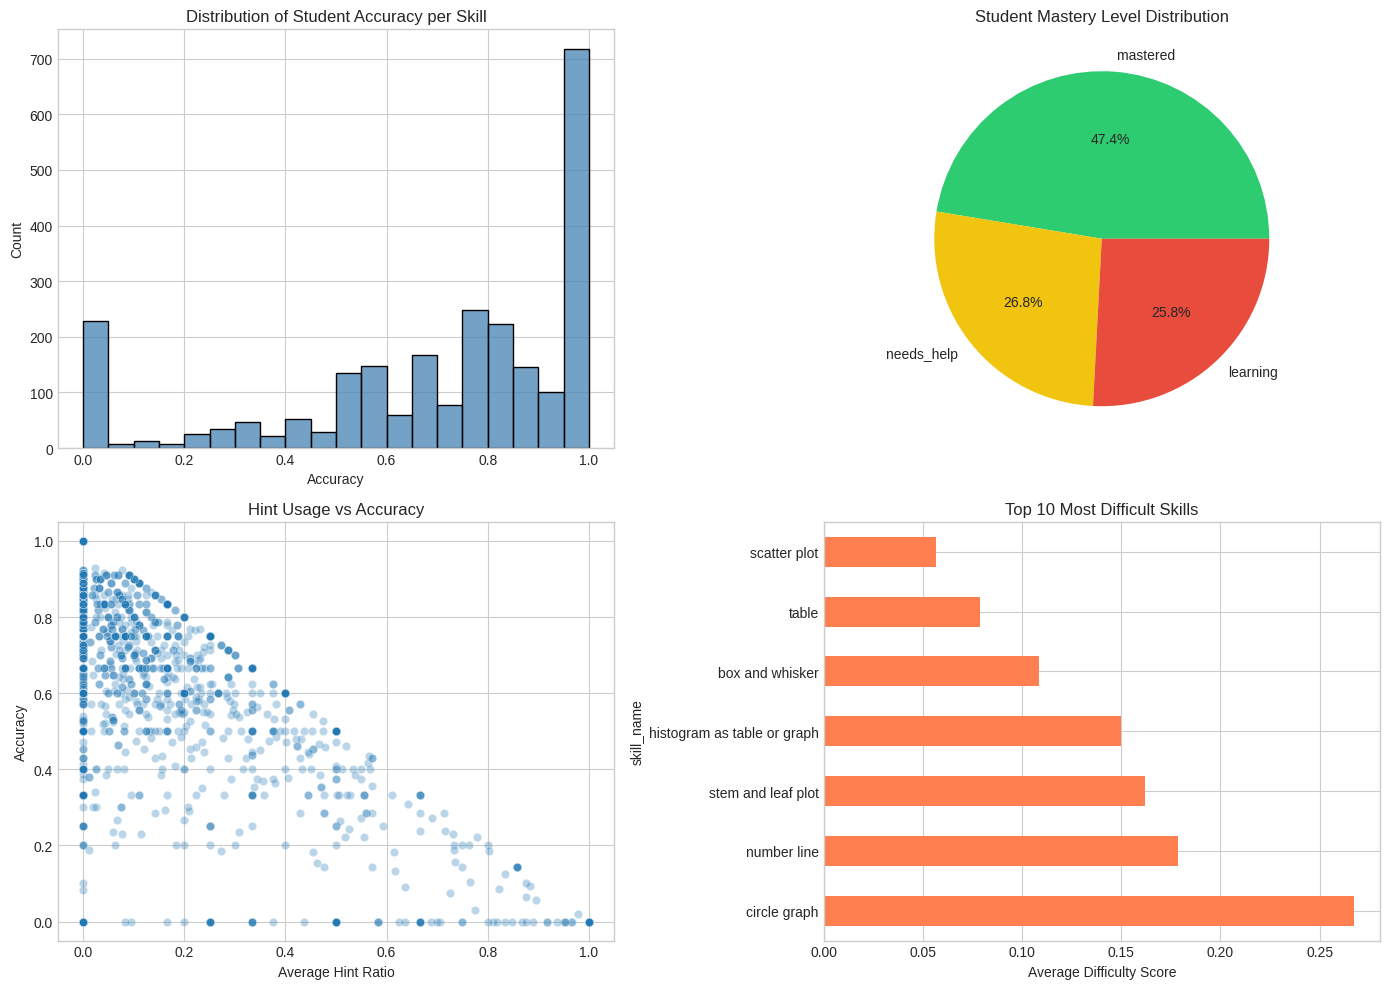

In [41]:
# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Distribution of student accuracy by skill
ax1 = axes[0, 0]
sns.histplot(data=student_skill_performance, x='accuracy', bins=20, ax=ax1, color='steelblue')
ax1.set_title('Distribution of Student Accuracy per Skill', fontsize=12)
ax1.set_xlabel('Accuracy')

# 2. Mastery level distribution
ax2 = axes[0, 1]
mastery_counts = student_skill_performance['mastery_level'].value_counts()
colors = ['#2ecc71', '#f1c40f', '#e74c3c']
ax2.pie(mastery_counts, labels=mastery_counts.index, autopct='%1.1f%%', colors=colors)
ax2.set_title('Student Mastery Level Distribution', fontsize=12)

# 3. Hint usage vs Accuracy
ax3 = axes[1, 0]
sample = student_skill_performance.sample(min(5000, len(student_skill_performance)))
sns.scatterplot(data=sample, x='avg_hint_ratio', y='accuracy', alpha=0.3, ax=ax3)
ax3.set_title('Hint Usage vs Accuracy', fontsize=12)
ax3.set_xlabel('Average Hint Ratio')
ax3.set_ylabel('Accuracy')

# 4. Top 10 most difficult skills
ax4 = axes[1, 1]
skill_difficulty = student_skill_performance.groupby('skill_name')['difficulty_score'].mean().sort_values(ascending=False).head(10)
skill_difficulty.plot(kind='barh', ax=ax4, color='coral')
ax4.set_title('Top 10 Most Difficult Skills', fontsize=12)
ax4.set_xlabel('Average Difficulty Score')

plt.tight_layout()
plt.savefig('eda_visualizations.png', dpi=150, bbox_inches='tight')
plt.show()

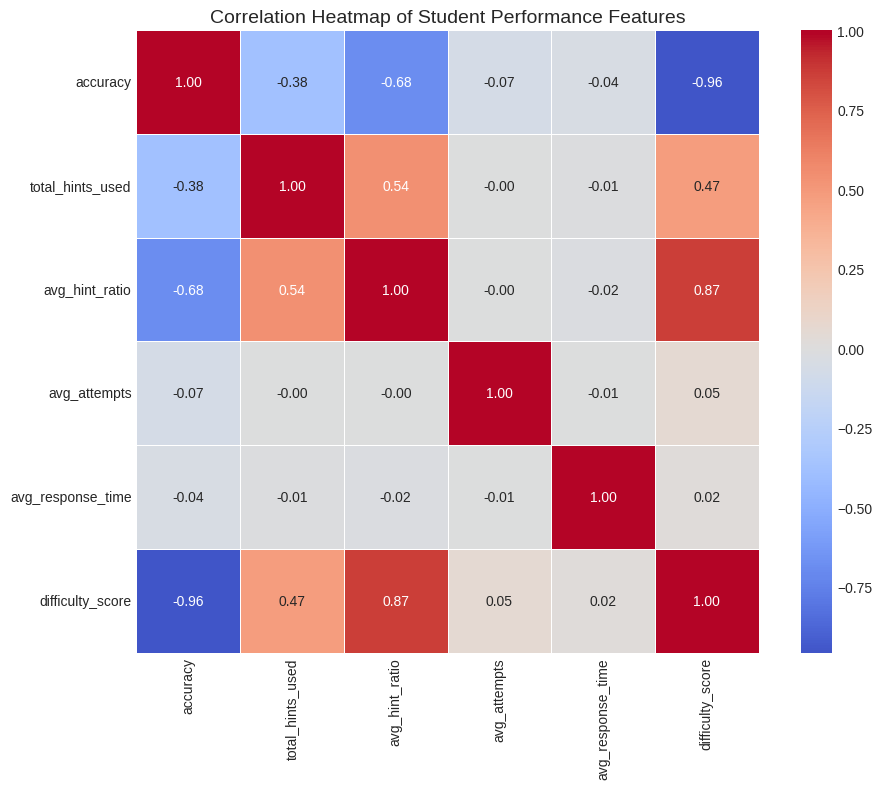

In [42]:
# Correlation heatmap of key features
plt.figure(figsize=(10, 8))

corr_cols = ['accuracy', 'total_hints_used', 'avg_hint_ratio',
             'avg_attempts', 'avg_response_time', 'difficulty_score']
corr_matrix = student_skill_performance[corr_cols].corr()

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
            fmt='.2f', square=True, linewidths=0.5)
plt.title('Correlation Heatmap of Student Performance Features', fontsize=14)
plt.tight_layout()
plt.savefig('correlation_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

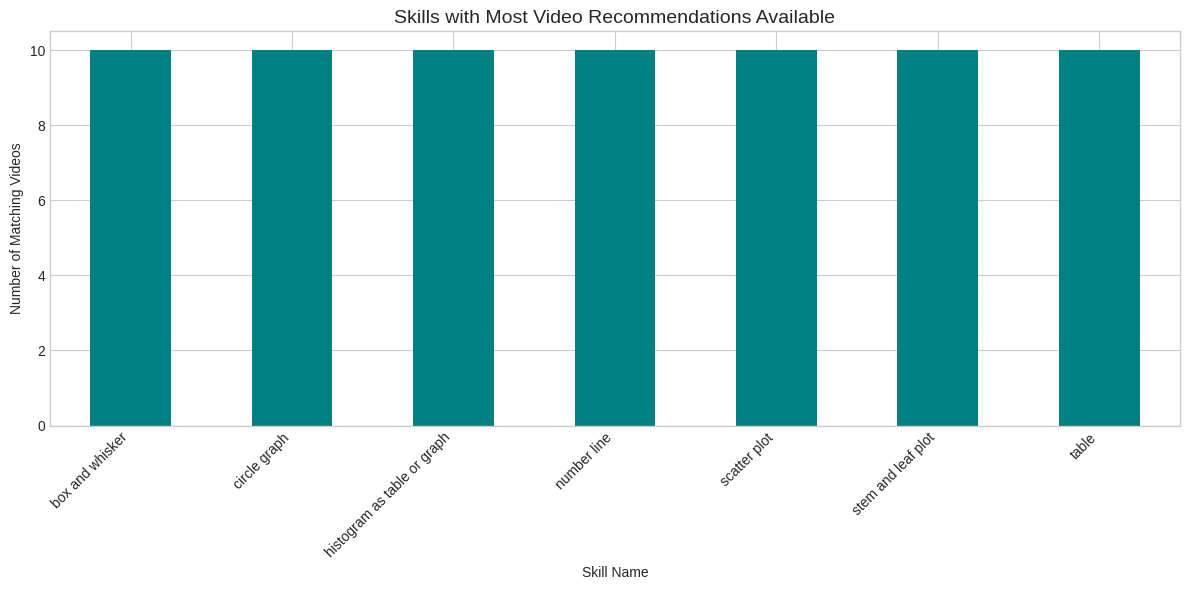

In [43]:
# Skills with most video matches
plt.figure(figsize=(12, 6))

video_coverage = skill_video_df.groupby('skill_name').size().sort_values(ascending=False).head(15)
video_coverage.plot(kind='bar', color='teal')
plt.title('Skills with Most Video Recommendations Available', fontsize=14)
plt.xlabel('Skill Name')
plt.ylabel('Number of Matching Videos')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('video_coverage.png', dpi=150, bbox_inches='tight')
plt.show()

## 10. Save Processed Datasets

In [44]:
# Save cleaned ASSISTments data
assistments_clean.to_csv('assistments_cleaned.csv', index=False)
print(f"Saved: assistments_cleaned.csv ({len(assistments_clean)} rows)")

# Save student-skill performance aggregation
student_skill_performance.to_csv('student_skill_performance.csv', index=False)
print(f"Saved: student_skill_performance.csv ({len(student_skill_performance)} rows)")

# Save skill-video mapping
skill_video_df.to_csv('skill_video_mapping.csv', index=False)
print(f"Saved: skill_video_mapping.csv ({len(skill_video_df)} rows)")

# Save final merged dataset
final_dataset.to_csv('final_recommender_dataset.csv', index=False)
print(f"Saved: final_recommender_dataset.csv ({len(final_dataset)} rows)")

Saved: assistments_cleaned.csv (20792 rows)
Saved: student_skill_performance.csv (2485 rows)
Saved: skill_video_mapping.csv (70 rows)
Saved: final_recommender_dataset.csv (24850 rows)


## 11. Dataset Summary Statistics

In [45]:
print("="*60)
print("PHASE 1 DATA COLLECTION SUMMARY")
print("="*60)

print("\n📊 DATASET 1: ASSISTments 2009-2010")
print(f"   - Total interactions: {len(assistments_clean):,}")
print(f"   - Unique students: {assistments_clean['user_id'].nunique():,}")
print(f"   - Unique problems: {assistments_clean['problem_id'].nunique():,}")
print(f"   - Unique skills: {assistments_clean['skill_name'].nunique()}")
print(f"   - Overall accuracy: {assistments_clean['correct'].mean()*100:.1f}%")

print("\n📺 DATASET 2: Khan Academy YouTube Videos")
print(f"   - Total videos: {len(khan_videos_df):,}")

print("\n🔗 MERGED DATASET")
print(f"   - Skills with video matches: {len(skill_video_mapping)}")
print(f"   - Total skill-video mappings: {len(skill_video_df):,}")
print(f"   - Final dataset rows: {len(final_dataset):,}")

print("\n📈 STUDENT PERFORMANCE BREAKDOWN")
print(f"   - Mastered skills: {(student_skill_performance['mastery_level']=='mastered').sum():,}")
print(f"   - Learning skills: {(student_skill_performance['mastery_level']=='learning').sum():,}")
print(f"   - Needs help: {(student_skill_performance['mastery_level']=='needs_help').sum():,}")

print("\n" + "="*60)

PHASE 1 DATA COLLECTION SUMMARY

📊 DATASET 1: ASSISTments 2009-2010
   - Total interactions: 20,792
   - Unique students: 1,172
   - Unique problems: 1,671
   - Unique skills: 7
   - Overall accuracy: 66.5%

📺 DATASET 2: Khan Academy YouTube Videos
   - Total videos: 4,453

🔗 MERGED DATASET
   - Skills with video matches: 7
   - Total skill-video mappings: 70
   - Final dataset rows: 24,850

📈 STUDENT PERFORMANCE BREAKDOWN
   - Mastered skills: 1,178
   - Learning skills: 642
   - Needs help: 665



## 12. Sample Recommendation Output

In [46]:
# Example: Get recommendations for a specific student
def get_student_recommendations(user_id, dataset, top_n=5):
    """
    Get video recommendations for a student based on their weak skills.
    """
    student_data = dataset[dataset['user_id'] == user_id].copy()

    # Filter to skills that need improvement and have video matches
    weak_skills = student_data[
        (student_data['mastery_level'] == 'needs_help') &
        (student_data['video_title'].notna())
    ]

    # Sort by recommendation priority
    recommendations = weak_skills.sort_values('recommendation_priority', ascending=False)

    return recommendations[['skill_name', 'accuracy', 'mastery_level',
                           'video_title', 'recommendation_priority']].head(top_n)

# Get a sample student
sample_user = final_dataset['user_id'].iloc[0]
print(f"Sample Recommendations for Student ID: {sample_user}")
print("-" * 50)
recommendations = get_student_recommendations(sample_user, final_dataset)
if len(recommendations) > 0:
    display(recommendations)
else:
    print("No recommendations needed - student has mastered all skills with video matches!")

Sample Recommendations for Student ID: 14
--------------------------------------------------


,skill_name,accuracy,mastery_level,video_title,recommendation_priority
0,circle graph,0.25,needs_help,Graphing a circle from its standard equation |...,0.658360
1,circle graph,0.25,needs_help,Features of a circle from its graph | Mathemat...,0.658360
2,circle graph,0.25,needs_help,Graphing circles from features | Mathematics I...,0.658360
3,circle graph,0.25,needs_help,Reading inverse values from a graph,0.591694
4,circle graph,0.25,needs_help,Multiplying complex numbers graphically exampl...,0.591694


---

## Next Steps (Phase 2)

1. **Feature Engineering**: Create more sophisticated features for the ML model
2. **Model Building**: Train a recommendation model (collaborative filtering, content-based, or hybrid)
3. **Evaluation**: Split data and evaluate recommendation quality
4. **GUI Development**: Build a Streamlit/Flask interface
5. **Deployment**: Deploy to cloud (Streamlit Cloud, HuggingFace Spaces, or Heroku)